In [11]:
import random
from copy import deepcopy
import math
import matplotlib.pyplot as plt
import numpy as np

In [12]:

def load(file):
    cities = []
    with open(file, 'r') as f:
        for line in f:
            data = line.split()
            city_num = int(data[0])-1
            x = float(data[1])
            y = float(data[2])
            demand = float(data[3])
            ready_time = float(data[4])
            due_time = float(data[5])
            
            city = {'city_num' : city_num, 'x' : x, 'y' : y, 'demand' : demand, 'ready_time' : ready_time, 'due_time' : due_time}
            cities.append(city)
            
    return cities   

In [13]:
input1 = load('resources/input_1.txt')
# for city in input1:
#     print(city)
input2 = load('resources/input_2.txt')
input3 = load('resources/input_3.txt')

In [14]:
class Individual:
    def __init__(self, data, capacity, num_of_vehicles, num_of_customers, service_time):
        self.num_of_vehicles = num_of_vehicles
        self.num_of_customers = num_of_customers
        self.depot = data[0]
        self.data = data
        self.capacity = capacity
        self.service_time = service_time

        self.solution = self.generate_solution_nearest_neighbour()
        self.fitness = self.calc_fitness()

    def __len__(self) -> int:
        return len(self.solution)
    
    def calc_distance(self, customer1, customer2):
        return math.sqrt((customer1["x"] - customer2["x"])**2 + (customer1["y"] - customer2["y"])**2)

    def generate_solution(self):
        pass
    
    def generate_solution_random(self):
        routes = [[] for _ in range(self.num_of_vehicles)]
        remaining = set(range(1, self.num_of_customers + 1))

        
        while remaining:
            customer_index = random.choice(list(remaining))
            id = 0
            for j in range(self.num_of_vehicles):
                if self.route_is_valid(routes[j], customer_index):
                    routes[j].append(customer_index)
                    remaining.remove(customer_index)
                    id = 1
                    break
            if id == 0: #ako nije pronadjena feasible ruta, restartujemo alg
                routes = [[] for _ in range(self.num_of_vehicles)]
                remaining = set(range(1, self.num_of_customers + 1))
        
        chromosome = []
        i = 1
        for x in routes:
            for c in x:
                chromosome.append(c)
            chromosome.append(self.num_of_customers + i)
            i += 1
                
        chromosome.pop(-1)

        return chromosome


        
    def route_is_valid(self, route, customer_index):
        fitness, current_time, remaining_capacity = self.route_fitness(route)
        if not route:
            return True
        if fitness == float('inf') or current_time == float('inf') or remaining_capacity < self.data[customer_index]["demand"] or current_time + self.calc_distance(self.data[route[-1]], self.data[customer_index]) > self.data[customer_index]["due_time"]:
            return False
        
        return True


    
    def generate_solution_nearest_neighbour(self):
        routes = [[] for _ in range(self.num_of_vehicles)]
        remaining = set(range(1, self.num_of_customers+1))
        selection_value = [(i,max(self.calc_distance(self.depot, self.data[i]), self.data[i]["ready_time"])) for i in range(1, self.num_of_customers+1) if self.data[i]["demand"] < self.capacity]
        selection_value.sort(key = lambda x: x[1])
        j = 0
        while remaining:
            customer_index = selection_value[0][0] # najmanji selection value 
            routes[j].append(customer_index)
            remaining.remove(customer_index)
            fitness, time, remaining_capacity = self.route_fitness(routes[j])
            selection_value = [(r, max(self.calc_distance(self.data[routes[j][-1]], self.data[r]), self.data[r]["ready_time"] - time)) for r in remaining if time + self.calc_distance(self.data[routes[j][-1]], self.data[r]) < self.data[r]["due_time"] and remaining_capacity >= self.data[r]["demand"]]
            selection_value.sort(key = lambda x: x[1])

            if not selection_value:
                j += 1
                selection_value = [(i,max(self.calc_distance(self.depot, self.data[i]), self.data[i]["ready_time"])) for i in remaining if self.data[i]["demand"] < self.capacity]
                selection_value.sort(key = lambda x: x[1])
                if j == self.num_of_vehicles:
                    routes = [[] for _ in range(self.num_of_vehicles)]
                    remaining = set(range(1, self.num_of_customers+1))
                    selection_value = [(i,max(self.calc_distance(self.depot, self.data[i]), self.data[i]["ready_time"])) for i in range(1, self.num_of_customers+1) if self.data[i]["demand"] < self.capacity]
                    selection_value.sort(key = lambda x: x[1])
                    j = 0

        chromosome = []
        i = 1
        for x in routes:
            for c in x:
                chromosome.append(c)
            chromosome.append(self.num_of_customers + i)
            i += 1
                
        chromosome.pop(-1)

        return chromosome




    def generate_solution_sweep(self):
        pass

    def route_fitness(self, route):
        if not route:
            return 0, 0, self.capacity
        
        fitness = 0
        current_time = 0
        current_node = self.depot
        remaining_capacity = self.capacity 
        for r, i in zip(route, range(len(route))):

            if current_time + self.calc_distance(current_node, self.data[r]) > self.data[r]["due_time"] or remaining_capacity < self.data[r]["demand"]:
                return float('inf'), float('inf'), remaining_capacity - self.data[r]["demand"]
            else:
                current_time += max(self.calc_distance(current_node, self.data[r]), self.data[r]["ready_time"] - current_time) + self.service_time
                current_node = self.data[r]
                remaining_capacity -= self.data[r]["demand"]
            
        fitness += current_time + self.calc_distance(self.data[route[-1]], self.depot)
        
        return fitness, current_time, remaining_capacity
    
    def get_routes(self, solution):
        routes = []
        route = []
        # all routes except for the last route
        for node in solution:
            if node <= self.num_of_customers:
                route.append(node)
            else:
                if route is not []:
                    routes.append(route)
                route = []

        # last route
        if route is not []:
            routes.append(route)

        return routes
    
    def calc_fitness(self):
        routes = self.get_routes(self.solution)
        
        fitness = 0
        for route in routes:
            if len(route) == 0:
                continue
            f, _, _ = self.route_fitness(route)
            fitness += f
            
            
        return fitness

        # distance ~ isto sto i vreme 
        # vreme na putu + vreme cekanja (ako ga ima) + service time 
        # vreme cekanja = 0 ili ready time - arrival time

        # Di + distance(i,j) + wait time

        # penalizujemo resenja koja ne ispunjavaju uslove za time window

    def is_feasable(self, sol):
        # ponavljanje gradova
        # koriscenje vise vozila nego sto postoji 
        if len(sol) > self.num_of_vehicles:
            print("more vehicles than available violation")
            return False
        

        visited_customers = [False for _ in range(self.num_of_customers)]

        for route in sol:
            current_time = 0
            current_node = 0
            remaining_capacity = self.capacity
            for c in route:
                if remaining_capacity < self.data[c]["demand"]:
                #if remaining_capacity < self.data[c]["demand"]:
                    print("capacity violation")
                    return False
                elif current_time + self.calc_distance(self.data[current_node], self.data[c]) > self.data[c]["due_time"]:
                    print("time window violation ")
                    print(route)
                    return False
                else:
                    current_time += max(self.calc_distance(self.data[current_node], self.data[c]), self.data[c]["ready_time"] - current_time) + self.service_time
                    current_node = c
                    remaining_capacity -= self.data[c]["demand"]
                    if visited_customers[c-1]:
                        print("visiting same customer multiple times violation")
                        return False
                    visited_customers[c-1] = True
        if not all(visited_customers):
            print("not all customers visited violation")
        return all(visited_customers)
        

# Selection

In [15]:
def random_selection(population):
    return random.choice(population)

In [16]:
def tournament_selection(population, tournament_size):
    tournament = random.sample(population, tournament_size)
    return max(tournament, key = lambda x: x.fitness)

In [17]:
def roulette_selection(population):
    total_fitness = sum([individual.fitness for individual in population])
    selection_probs = [individual.fitness / total_fitness for individual in population]
    return random.choices(population, weights=selection_probs)[0]

In [18]:
def rang_selection(population):
    n = len(population)
    rang_sum = n * (n+1) / 2
    selection_probs = []
    for rang, _ in enumerate(sorted(population, key=lambda x: x.fitness), 1):
        selection_probs.append(rang / rang_sum)
        
    return random.choices(population, weights=selection_probs)[0]

In [19]:
def selection(param, population):
    if param["tournament_size"] is not None:
        return param["selection"](population, param["tournament_size"])
    else:
        return param["selection"](population)

In [20]:
class Example_Individual:
    def __init__(self, fitness, name):
        self.fitness = fitness
        self.name = name

example_population = [Example_Individual(fitness=0.8, name='A'), 
                      Example_Individual(fitness=0.6, name='B'), 
                      Example_Individual(fitness=0.7, name='C'),
                      Example_Individual(fitness=0.8, name='D'), 
                      Example_Individual(fitness=0.9, name='E')]

print(random_selection(example_population).name)
print(tournament_selection(example_population, 3).name)
print(roulette_selection(example_population).name)
print(rang_selection(example_population).name)

C
D
E
C


# Crossover

In [21]:
def order_crossover(parent1, parent2, child1, child2):
    def oc(p1, p2, ch):
        lb, ub = sorted(random.sample(range(len(p1) + 1), 2))
        ch[lb:ub] = p1[lb:ub]

        j = 0
        for i in range(len(p2)):
            if j == lb:
                j = ub + 1

            if j >= len(ch):
                break

            if p2[i] not in ch:
                ch[j] = p2[i]
                j = j + 1 

        return ch
    
    
    child1 = oc(parent1, parent2, child1)
    child2 = oc(parent2, parent1, child2)
    
    return child1, child2

In [22]:
def partially_mapped_crossover(parent1, parent2, child1, child2):
    cutoff_1, cutoff_2 = sorted(random.sample(range(len(parent1) + 1), 2))
    
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)
    
    child1[cutoff_1:cutoff_2] = parent2[cutoff_1:cutoff_2]
    child2[cutoff_1:cutoff_2] = parent1[cutoff_1:cutoff_2]

   

    middle_map = {}
    for a, b in zip (child1[cutoff_1:cutoff_2], child2[cutoff_1:cutoff_2]):
        middle_map[a] = middle_map.get(a, 0) + 1
        middle_map[b] = middle_map.get(b, 0) + 1
        
    mapping_order = []
    for key, value in middle_map.items():
        if value != 2:
            mapping_order.append(key)
            
    def find_all_occurrences(lst, item):
        return [i for i, x in enumerate(lst) if x == item]    
          
    def replace_a_b(x_pos, y, child, cutoff_1, cutoff_2):
        for i in x_pos:
            if i not in range(cutoff_1, cutoff_2):
                child[i] = y
                break 
                   
        return child
        
    def replace_a_b_child(a, a_pos, b, b_pos, child, cutoff_1, cutoff_2):
        if len(a_pos) != 0:
             return replace_a_b(a_pos, b, child, cutoff_1, cutoff_2)
        else:
            return replace_a_b(b_pos, a, child, cutoff_1, cutoff_2)
        
    for i in range(0, len(mapping_order)-1, 2):
        a = mapping_order[i]
        b = mapping_order[i+1]

        a_child1_positions = find_all_occurrences(child1, a)
        a_child2_positions = find_all_occurrences(child2, a)
        
        
        b_child1_positions = find_all_occurrences(child1, b)
        b_child2_positions = find_all_occurrences(child2, b)
        
        child1 = replace_a_b_child(a, a_child1_positions, b, b_child1_positions, child1, cutoff_1, cutoff_2)
        child2 = replace_a_b_child(a, a_child2_positions, b, b_child2_positions, child2, cutoff_1, cutoff_2)

    return child1, child2

[1 | 2 3 4 | 5]  
[5 | 4 3 1 | 2]   

[1 | 4 3 1 | 5]   
[5 | 2 3 4 | 2]   

4-2, 3-3, 1-4

1: 1   
2: 1   
3: 2   
4: 2  
1 -> 2  

[2 | 1 3 4 | 5]    
[5 | 2 3 4 | 1]    

In [23]:
def best_route_better_adjustment_crossover(individual, parent1, parent2, child1, child2):
    # n/2 best from parent1 into first n/2 of child1
    # the rest elements are from parent2 
    # the positions of vehicles are fixed
        
    def create_child(p1, p2, ch1):
        p1_routes = individual.get_routes(p1)
        p1_sorted = sorted(p1_routes, key = lambda route: individual.route_fitness(route))

        # copy half of the best routes from parent1 to child 1
        best_routes_index = 0
        i = 0
        node_index = 0
        while best_routes_index <= len(p1_sorted) / 2:
            node = ch1[node_index]
            if node <= individual.num_of_customers and i < len(p1_sorted[best_routes_index]):
                ch1[node_index] = p1_sorted[best_routes_index][i]
                i = i + 1
            else:
                best_routes_index = best_routes_index + 1
                i = 0

            node_index = node_index + 1

        # copy elements from parent2 that aren't in child so far
        p2_index = 0
        while node_index < len(ch1):
            node = ch1[node_index]
            if node <= individual.num_of_customers:
                p2_node = p2[p2_index]
                if p2_node > individual.num_of_customers:
                    p2_index = p2_index + 1
                    p2_node = p2[p2_index]
                
                if p2_node not in ch1[:node_index]:
                    ch1[node_index] = p2_node
                p2_index = p2_index + 1

            node_index = node_index + 1
            
        return ch1
    
    child1 = create_child(parent1, parent2, child1)
    child2 = create_child(parent2, parent1, child2)
    return child1, child2

In [24]:
def crossover(param, parent1, parent2, child1, child2):
    if param["individual"] is not None:
        return param["crossover"](param["individual"], parent1, parent2, child1, child2)
    else:
        return param["crossover"](parent1, parent2, child1, child2)

# Mutation

In [25]:
def swap_mutation(individual):
    l, r = sorted(random.sample(range(len(individual)), 2))
    individual[l], individual[r] = individual[r], individual[l]
    
    return individual

In [26]:
def invert_mutation(individual):
    l, r = sorted(random.sample(range(len(individual) + 1), 2))
    chosen = individual[l:r]
    chosen.reverse()
    individual[l:r] = chosen
    
    return individual

In [27]:
def shaking_mutation(individual):
    l, r = sorted(random.sample(range(len(individual) + 1), 2))
    chosen = individual[l:r]
    random.shuffle(chosen)
    individual[l:r] = chosen
    
    return individual

In [28]:
def mutation(param, individual, mutation_prob):
    if random.random() < mutation_prob:
        individual = param(individual)
        
    return individual

# Genetic algorithm

In [29]:
def genetic_algorithm(params):
    
    data = params["data"]
    capacity = params["capacity"]
    num_of_vehicles = params["num_of_vehicles"]
    service_time = params["service_time"]
    population_size = params["population_size"]
    num_generations = params["num_generations"]
    elitism_size = params["elitism_size"]
    tournament_size = params["tournament_size"]
    selection_params = params["selection"]
    crossover_param = params["crossover"]
    mutation_params = params["mutation"]
    mutation_prob = params["mutation_prob"]
    
    population = [Individual(data, capacity, num_of_vehicles, len(data)-1, service_time ) for _ in range(population_size)]
    new_population = deepcopy(population)
  
    crossover_params = { "crossover" : crossover_param, 
                         "individual" : population[0] if crossover_param.__name__ == "best_route_better_adjustment_crossover" else None }
    best_solutions = []
    for i in range(num_generations):
        population.sort(key = lambda x: x.fitness)
        best_solutions.append(population[0])
        new_population[:elitism_size] = population[:elitism_size]
        for j in range(elitism_size, population_size, 2):
            parent1 = selection(selection_params, population)
            parent2 = selection(selection_params, population)
            
            while(parent1 == parent2):
                parent2 = selection(selection_params, population)
            
            new_population[j].solution, new_population[j+1].solution = crossover(crossover_params, 
                                                                                 parent1.solution, 
                                                                                 parent2.solution, 
                                                                                 new_population[j].solution, 
                                                                                 new_population[j+1].solution)
            
            new_population[j].solution = mutation(mutation_params, new_population[j].solution, mutation_prob)
            new_population[j+1].solution = mutation(mutation_params, new_population[j+1].solution, mutation_prob)

            new_population[j].fitness = new_population[j].calc_fitness()
            new_population[j+1].fitness = new_population[j+1].calc_fitness()

        population = deepcopy(new_population)
        
    
    return min(population, key = lambda x: x.fitness), best_solutions

In [30]:
POPULATION_SIZE = 1000
ELITISIM_SIZE = 100
MUTATION_PROB = 0.1
TOURNAMENT_SIZE = 300
NUM_GENERATIONS = 100
CAPACITY = 200
SELECTION = tournament_selection
CROSSOVER = order_crossover
MUTATION = invert_mutation
NUM_OF_VEHICLES = 50
SERVICE_TIME = 10

params = {
    "data" : input1,
    "population_size" : POPULATION_SIZE,
    "elitism_size" : ELITISIM_SIZE,
    "mutation_prob" : MUTATION_PROB,
    "tournament_size" : TOURNAMENT_SIZE,
    "num_generations" : NUM_GENERATIONS,
    "capacity" : CAPACITY,
    "selection" : { "selection" : SELECTION, 
                    "tournament_size" : TOURNAMENT_SIZE if SELECTION.__name__ == "tournament_selection" else None
                  },
    "crossover" : CROSSOVER,
    "mutation" : MUTATION,
    "num_of_vehicles" : NUM_OF_VEHICLES,
    "service_time" : SERVICE_TIME
}

ga_order_crossover, best_solutions_order_crossover = genetic_algorithm(params)

params["crossover"] = partially_mapped_crossover

ga_pmc, best_solutions_pmc = genetic_algorithm(params)

params["crossover"] = best_route_better_adjustment_crossover

ga_brbac, best_solutions_brbac = genetic_algorithm(params)


In [46]:
ga_order_crossover.is_feasable(ga_order_crossover.get_routes(ga_order_crossover.solution))

more vehicles than available violation


False

In [47]:
ga_pmc.is_feasable(ga_pmc.get_routes(ga_pmc.solution))

more vehicles than available violation


False

In [45]:
ga_brbac.is_feasable(ga_brbac.get_routes(ga_brbac.solution))

more vehicles than available violation


False

egzaktan, grafovi, viseciljna, reference, prezentacija i pdf



# Graphs

In [31]:
def plot_customers(x_coordinates, y_coordinates, dataset_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(x_coordinates[1:], y_coordinates[1:], color='red', label='Customers')
    plt.scatter(x_coordinates[0], y_coordinates[0], color='blue', label='Depot') 
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Customer Coordinates for ' + dataset_name)
    plt.legend()
    plt.grid(True)
    plt.show()

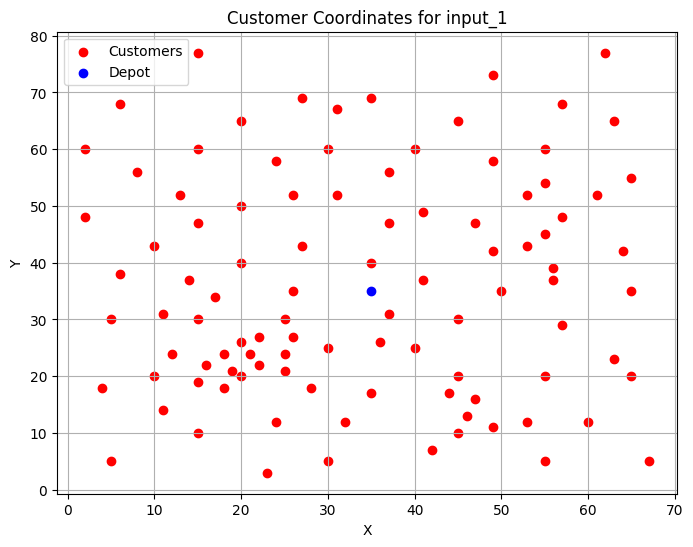

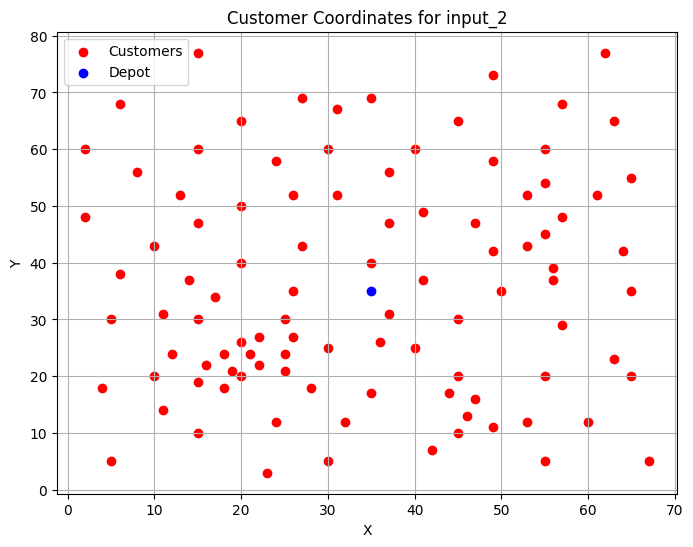

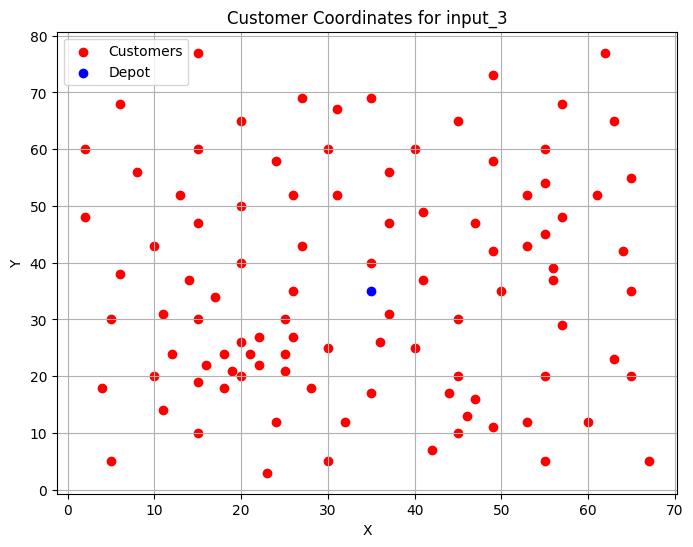

In [32]:
x_input1 = [x["x"] for x in input1]
y_input1 = [x["y"] for x in input1]

x_input2 = [x["x"] for x in input2]
y_input2 = [x["y"] for x in input2]

x_input3 = [x["x"] for x in input3]
y_input3 = [x["y"] for x in input3]


plot_customers(x_input1, y_input1, "input_1")
plot_customers(x_input2, y_input2, "input_2")
plot_customers(x_input3, y_input3, "input_3") #deluju mi isto 

In [40]:
#Best solution routes 
def plot_best_solution(x, title):
    plt.figure(figsize=(8, 6))
    routes = x.get_routes(x.solution)
    for route in routes:
        x_points  = np.array([x.depot["x"]])
        x_points = np.append(x_points, [x.data[i]["x"] for i in route], axis = 0)
        x_points = np.append(x_points, [x.depot["x"]], axis = 0)
        y_points  = np.array([x.depot["y"]])
        y_points = np.append(y_points, [x.data[i]["y"] for i in route], axis = 0)
        y_points = np.append(y_points, [x.depot["y"]], axis = 0)
        

        plt.plot(x_points, y_points)
    
    plt.title(title)
    plt.show


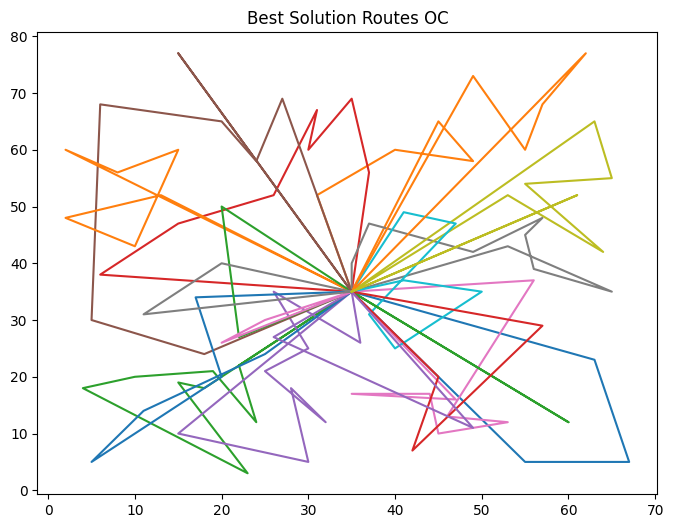

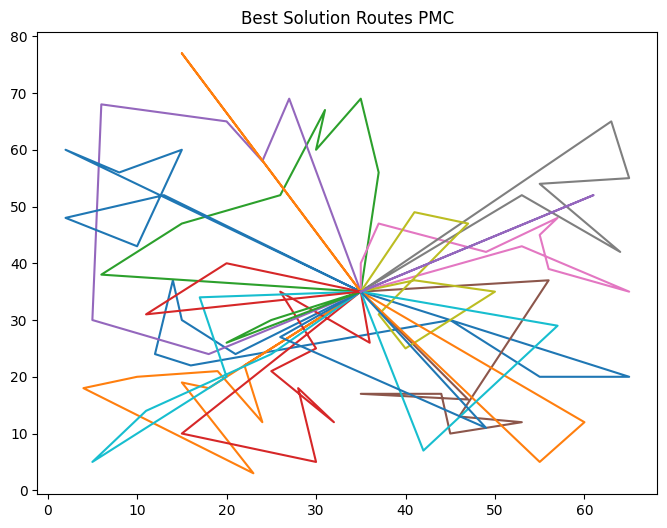

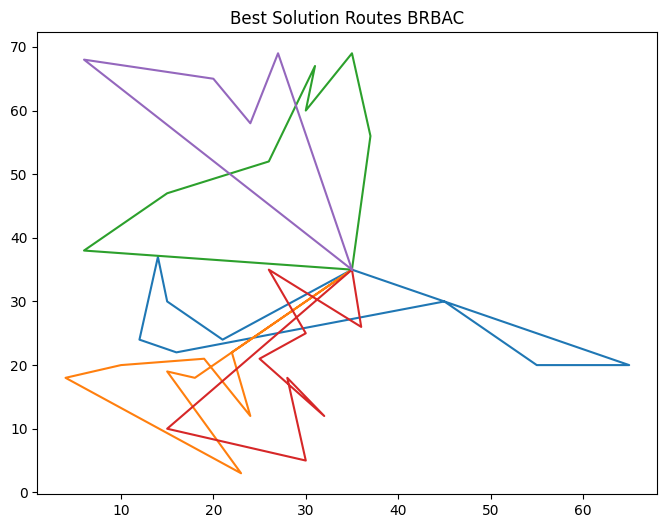

In [42]:
plot_best_solution(ga_order_crossover, "Best Solution Routes OC")
plot_best_solution(ga_pmc, "Best Solution Routes PMC")
plot_best_solution(ga_brbac, "Best Solution Routes BRBAC") 

In [51]:
def best_solution_evolution(solutions, title, info):
    plt.figure(figsize=(8, 6))
    y_points = [[] for _ in range(len(solutions))]
    i = 0
    for solution in solutions:
        y_points[i] = [x.fitness for x in solution]
        i+=1
    
    for i,y in enumerate(y_points):
        plt.plot(np.array(y), label = info[i])
    plt.title(title)
    plt.ylabel("fitness")
    plt.xlabel("generation")
    plt.legend()
    plt.show()

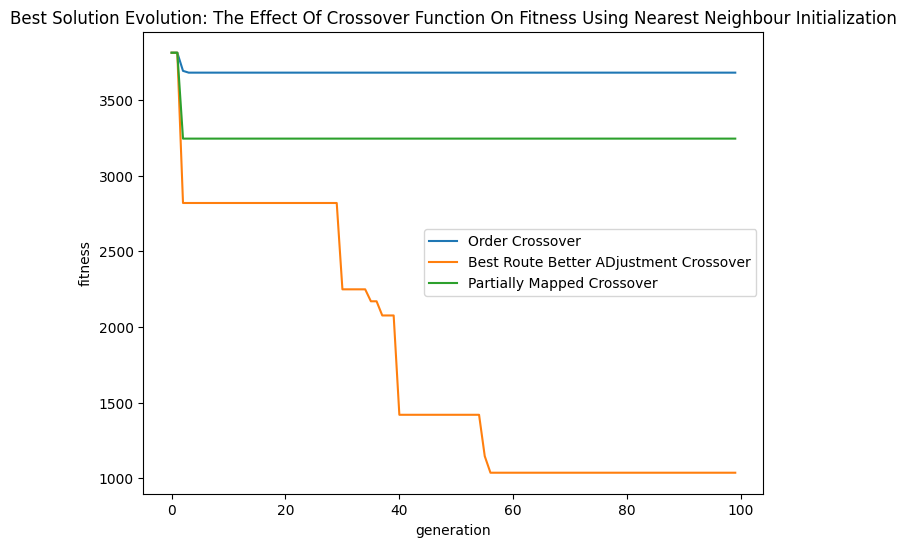

In [53]:
best_solution_evolution([best_solutions_order_crossover,best_solutions_brbac, best_solutions_pmc], "The Effect Of Crossover Function On Fitness Using Nearest Neighbour Initialization", ["Order Crossover", "Best Route Better ADjustment Crossover", "Partially Mapped Crossover"])